In [1]:
# Notre DIP
!git clone https://github.com/quentgar/deep_image_prior.git
!mv deep_image_prior/* ./

!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep_image_prior'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 68 (delta 12), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (68/68), done.
Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 24.17 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [2]:
pip install voxelmorph

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 


In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.skip import skip
from src.hourglass_network import *
import torch
import torch.optim

from utils.inpainting_utils import *
from skimage.measure import compare_psnr

from voxelmorph.torch.layers import SpatialTransformer
import seaborn as sns

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 32

In [59]:
img1_path = 'mydata/brosse1.jpg'
img2_path = 'mydata/brosse2.jpg'
mask_path = 'mydata/brosse1_mask.jpg'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

In [60]:
img_pil1, img_np1 = get_image(img1_path, imsize)
img_pil2, img_np2 = get_image(img2_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

In [61]:
img_pil1 = crop_image(img_pil1, dim_div_by)
img_pil2 = crop_image(img_pil2, dim_div_by)
img_mask_pil = crop_image(img_mask_pil, dim_div_by)

img_np1 = pil_to_np(img_pil1)
img_np2 = pil_to_np(img_pil2)
img_mask_np = pil_to_np(img_mask_pil)

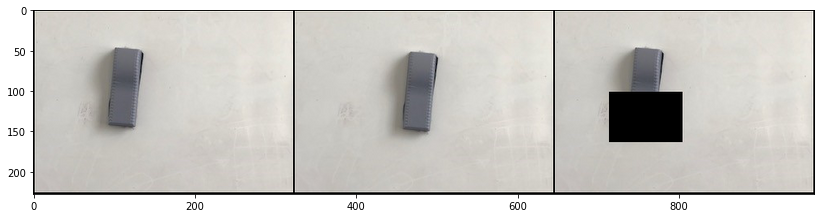

In [62]:
plot_image_grid([img_np1, img_np2, img_np1*img_mask_np], 3,11);

In [63]:
size = img_np1.shape[1:]

In [64]:
def optimize_perso(optimizer_type, parameters1, parameters2, closure, LR, num_iter):
    print('Starting optimization with ADAM')
    optimizer_inpainting = torch.optim.Adam(parameters1, lr=LR)
    optimizer_recalage = torch.optim.Adam(parameters2, lr=LR)
    
    for j in range(num_iter):
        # Optimiser paramètres inpainting
        optimizer_inpainting.zero_grad()
        closure()
        optimizer_inpainting.step()

        # Optimiser paramètres recalage
        optimizer_recalage.zero_grad()
        closure()
        optimizer_recalage.step()

In [65]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [88]:
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 1000
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03
depth = 5

net_recalage = build_hourglass(input_depth, output_depth=2, 
            num_channels_down = [128]*depth,
            num_channels_up =   [128]*depth,
            num_channels_skip =    [4]*depth,  
            filter_size_up = 3, filter_size_down = 3, 
            up_samp_mode='nearest', filter_skip_size=1,num_scales=depth,need_sigmoid=False).type(dtype)

net_inpainting = build_hourglass(input_depth, output_depth=img_np1.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [0]*depth,  
               filter_size_up = 3, filter_size_down = 3, 
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)

"""
net = skip(input_depth, img_np.shape[0], 
            num_channels_down = [128] * 5,
            num_channels_up   = [128] * 5,
            num_channels_skip = [0] * 5,  
            upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)"""

net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)
#net_input.div_(10)

# Spatial transformer
transformer = SpatialTransformer(size)

In [89]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net_recalage.parameters())
print ('Number of params recalage: %d' % s)

s  = sum(np.prod(list(p.size())) for p in net_inpainting.parameters())
print ('Number of params inpainting: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var1 = np_to_torch(img_np1).type(dtype)
img_var2 = np_to_torch(img_np2).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params recalage: 2218086
Number of params inpainting: 2192515


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


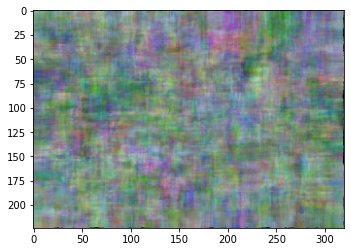

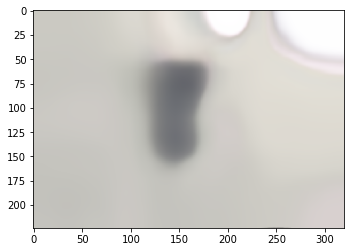

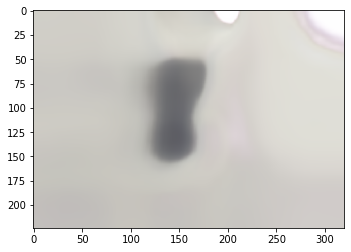

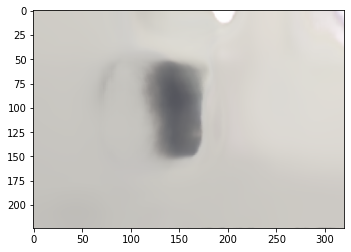

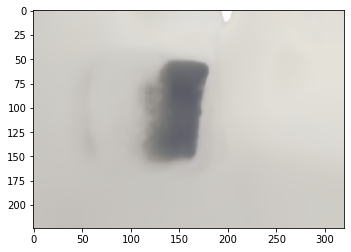

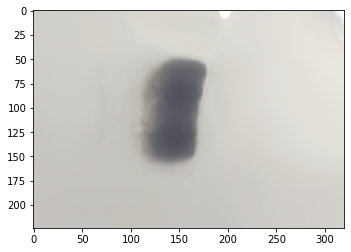

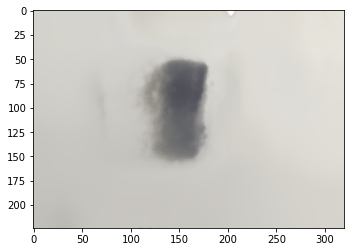

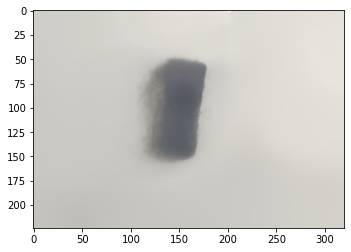

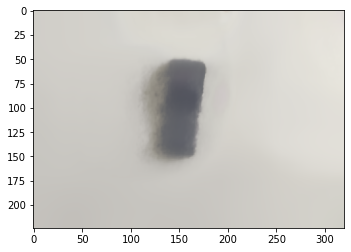

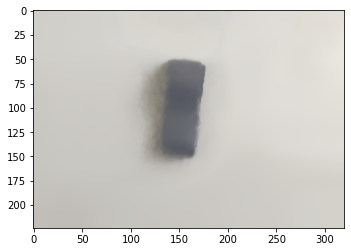

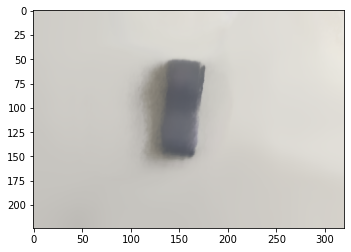

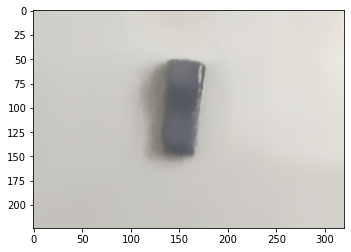

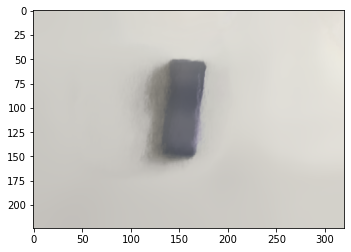

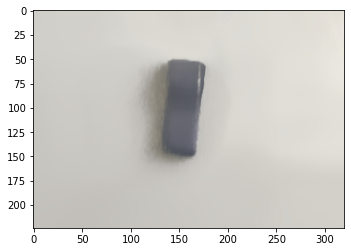

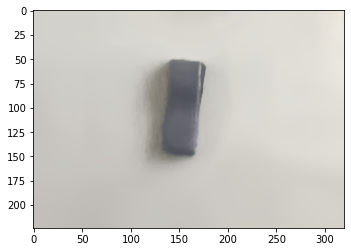

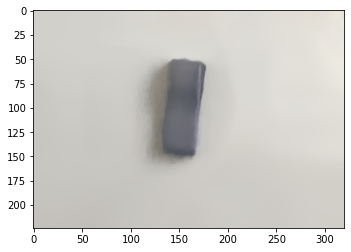

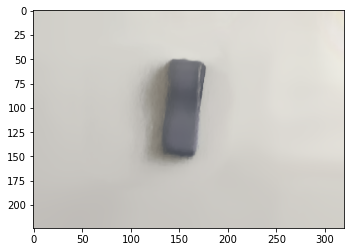

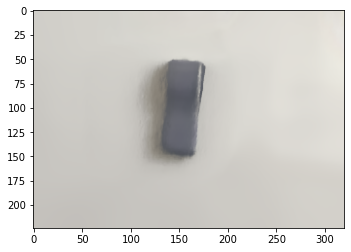

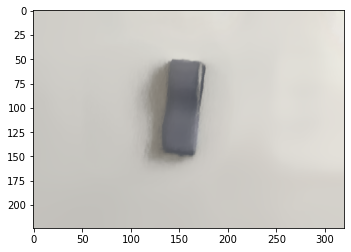

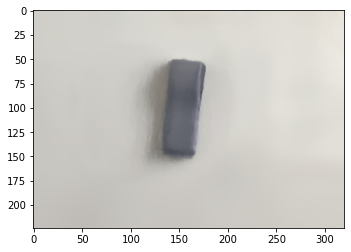

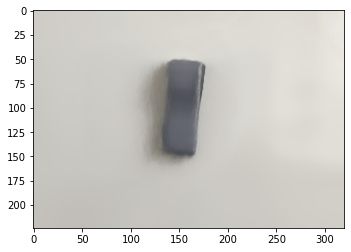

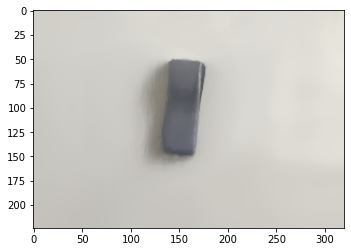

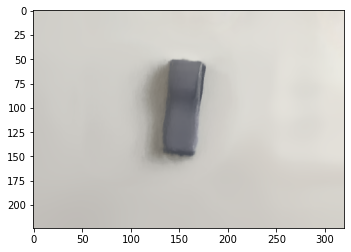

In [ ]:
i = 0
list_iter = []
list_psnr = []
list_loss = []

l1 = 4
l2 = 1

def closure():
    
    global i, list_iter, list_psnr, list_loss, inp_prec, flow_prec
    
    if param_noise:
        for n in [x for x in net_inpainting.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
        for n in [x for x in net_recalage.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    inp_prec = net_inpainting(net_input)
    flow_prec = net_recalage(net_input)
    
    out_trans = transformer(inp_prec.type(torch.FloatTensor),flow_prec.type(torch.FloatTensor)).type(dtype)
   
    total_loss = l1*mse(out_trans, img_var2) + l2*mse(inp_prec * mask_var, img_var1 * mask_var)
    total_loss.backward()
        
    if PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        out_np = torch_to_np(out_trans)
        list_iter.append(i)
        list_psnr.append(compare_psnr(img_np2,out_np))
        list_loss.append(total_loss.item())
        plt.imshow(out_np.transpose(1,2,0))
        plt.show()
        #plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p1 = get_params(OPT_OVER, net_inpainting, net_input)
p2 = get_params(OPT_OVER, net_recalage, net_input)

optimize_perso(OPTIMIZER, p1, p2, closure, LR, num_iter)

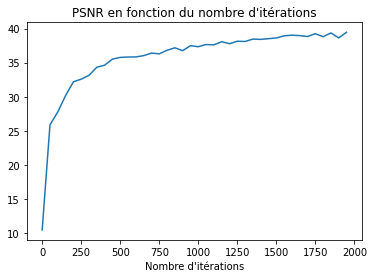

In [80]:
plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

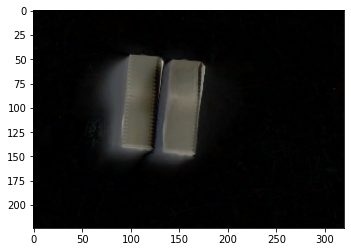

In [81]:
out_inp = net_inpainting(net_input)
out_rec = net_recalage(net_input)
out_trans = transformer(out_inp.type(torch.FloatTensor),out_rec.type(torch.FloatTensor)).type(dtype)
out_np = torch_to_np(out_trans)
t = abs(img_np1 - out_np)
plt.imshow(t.transpose(1,2,0))

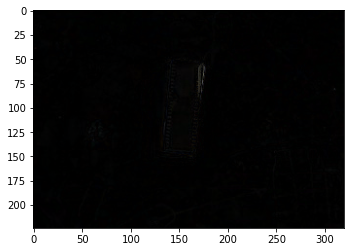

In [82]:
diff = abs(img_np2 - out_np)
plt.imshow(diff.transpose(1,2,0))

In [83]:
v_np = torch_to_np(out_rec)

In [84]:
u = v_np[0]
v = v_np[1]

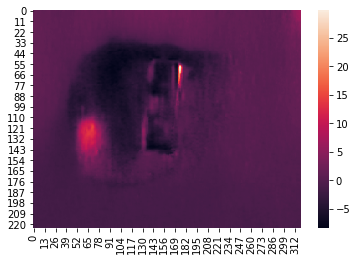

In [85]:
#norme = np.sqrt(u**2 + v**2)
ax = sns.heatmap(u)
plt.show()

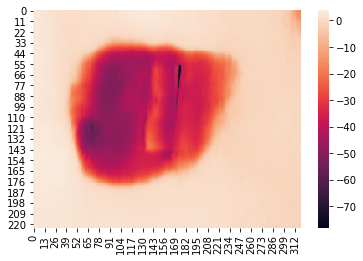

In [86]:
ax = sns.heatmap(v)
plt.show()

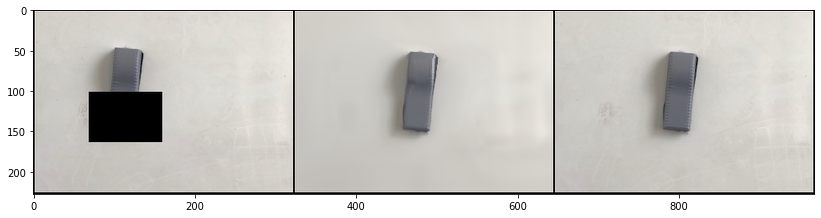

In [87]:
plot_image_grid([img_np1*img_mask_np, out_np, img_np2], 3,11);

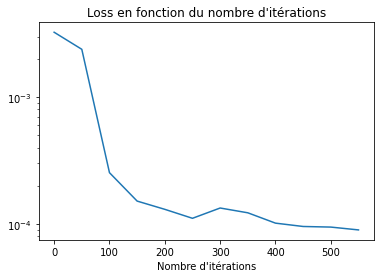

In [ ]:
plt.figure()
plt.semilogy(list_iter,list_loss,linestyle='-')
plt.title("Loss en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

In [ ]:
max(list_psnr)

38.6028760703398

In [ ]:
Ut = best_flow[:,1,:,:]
Vt = best_flow[:,0,:,:]
#print(Ut.shape)
Ut = torch_to_np(Ut)
Vt = torch_to_np(Vt)
#print(Ut.shape)
echant_div = 10
U = Ut[0:size[0]:echant_div, 0:size[1]:echant_div]
V = Vt[0:size[0]:echant_div, 0:size[1]:echant_div]
#print(U.shape)
#print(V.shape)

X, Y = np.meshgrid(np.arange(0, U.shape[1], 1), np.arange(0, U.shape[0], 1))
#print(X.shape)
#print(Y.shape)

x_shape = X.shape

plt.quiver(X,-Y,-U,V, units='xy' ,scale=X.mean()*2, color='red')
plt.show()